# Flower Recognition CNN Keras

## [ Please upvote / star if you like it ;)  ]

In [3]:
import os
# print(os.listdir('../input/flowers/flowers'))

In [6]:
!pip install opencv-python

In [8]:
!pip install tqdm

## CONTENTS ::

[ **1 ) Importing Various Modules**](#content1)

[ **2 ) Preparing the Data**](#content2)

[ **3 ) Modelling**](#content3)

[ **4 ) Evaluating the Model Performance**](#content4)

[ **5 ) Visualizing Predictons on the Validation Set**](#content5)

<a id="content1"></a>
## 1 ) Importing Various Modules.

In [1]:
# Ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# configure
# sets matplotlib to inline and displays graphs below the corresponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid', color_codes=True)

# model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

# preprocess
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# dl libraries
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop
from tensorflow.keras.utils import to_categorical

# specifically for cnn
from tensorflow.keras.layers import Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2
from tqdm import tqdm
import os
from random import shuffle
from zipfile import ZipFile
from PIL import Image


<a id="content2"></a>
## 2 ) Preparing the Data

## 2.1) Making the functions to get the training and validation set from the Images

In [2]:
X=[]
Z=[]
IMG_SIZE=150
Garbage_bag_DIR='Bag Classes/Garbage Bag Images'
Plastic_bag_DIR='Bag Classes/Plastic Bag Images'
Paper_bag_DIR='Bag Classes/Paper Bag Images'


In [3]:
def assign_label(img,bag_type):
    return bag_type
    

In [4]:
def make_train_data(bag_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,bag_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))
        
        
        

In [5]:
make_train_data('Garbage',Garbage_bag_DIR)
print(len(X))

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:09<00:00, 547.33it/s]

5000


In [6]:
make_train_data('Paper',Paper_bag_DIR)
print(len(X))

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 560.42it/s]

10000


In [7]:
make_train_data('Plastic',Plastic_bag_DIR)
print(len(X))

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:09<00:00, 546.78it/s]

15000


## 2.2 ) Visualizing some Random Images

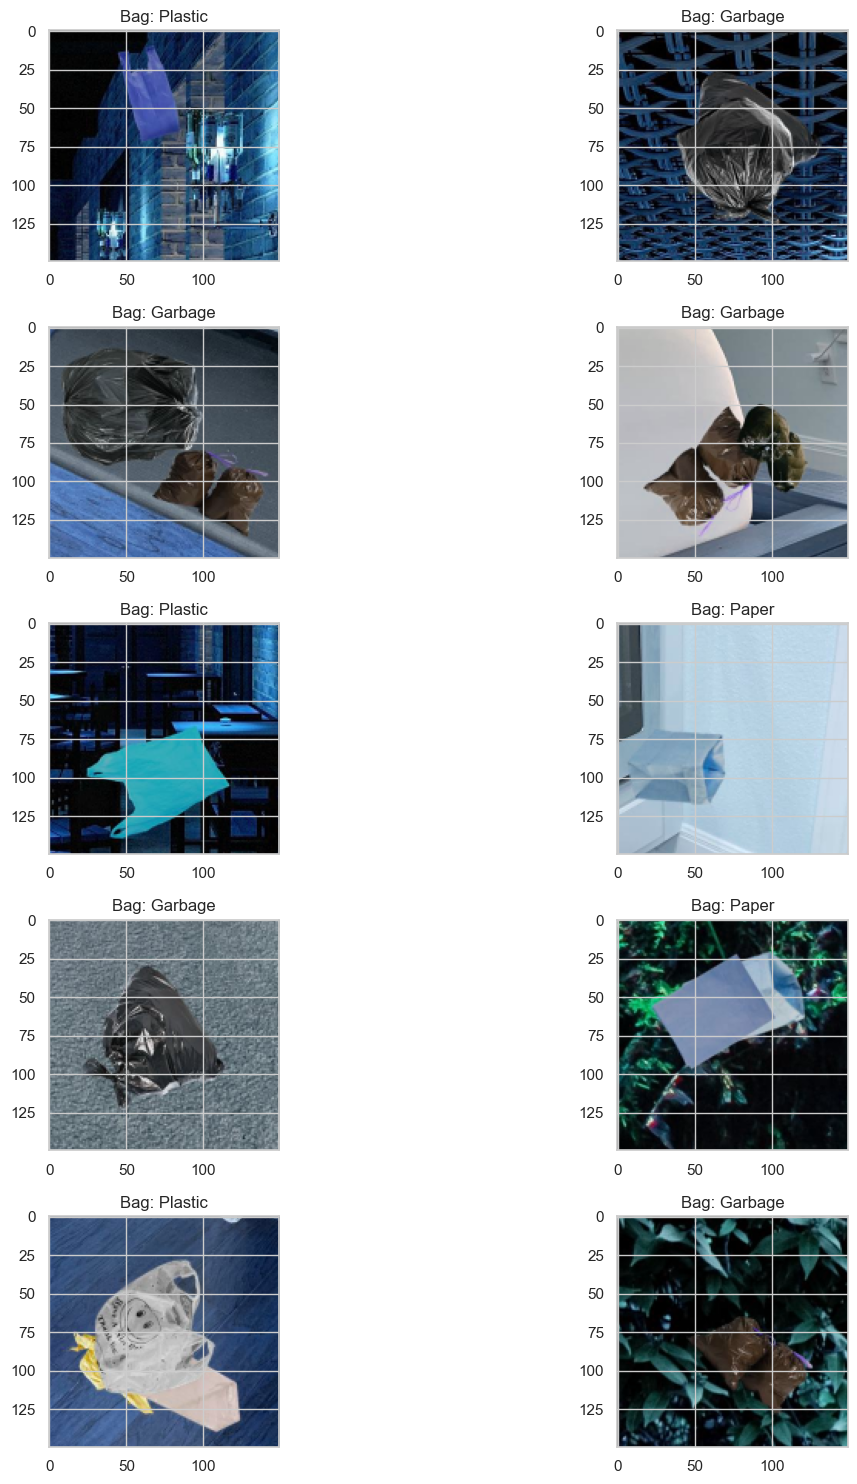

In [8]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Bag: '+Z[l])
        
plt.tight_layout()
        

## 2.3 ) Label Encoding the Y array (i.e. Daisy->0, Rose->1 etc...) & then One Hot Encoding

In [9]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,3)
X=np.array(X)
X=X/255

## 2.4 ) Splitting into Training and Validation Sets

In [10]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)


## 2.5 ) Setting the Random Seeds

In [11]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

<a id="content3"></a>
## 3 ) Modelling

## 3.1 ) Building the ConvNet Model

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation

# Modeling starts using a CNN
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu', input_shape=(150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=96, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=96, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(3, activation='softmax'))  # Changed to match the number of categories


## 3.2 ) Using a LR Annealer

In [13]:
batch_size=100
epochs=50

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

## 3.3 ) Data Augmentation to prevent Overfitting

In [14]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

## 3.4 ) Compiling the Keras Model & Summary

In [15]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 96)          │          55,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 96)          │          83,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 96)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 7776)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,981,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,142,723 (15.80 MB)

 Trainable params: 4,142,723 (15.80 MB)

 Non-trainable params: 0 (0.00 B)

## 3.5 ) Fitting on the Training set and making predcitons on the Validation set

In [17]:
History = model.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(x_test, y_test),
    verbose=1,
    steps_per_epoch=x_train.shape[0] // batch_size
)

# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 86s 745ms/step - accuracy: 0.5421 - loss: 0.9259 - val_accuracy: 0.8693 - val_loss: 0.3422
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.8100 - loss: 0.5279 - val_accuracy: 0.8589 - val_loss: 0.3549
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 70s 627ms/step - accuracy: 0.8388 - loss: 0.4218 - val_accuracy: 0.9123 - val_loss: 0.2671
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.9300 - loss: 0.2369 - val_accuracy: 0.9029 - val_loss: 0.3040
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 71s 629ms/step - accuracy: 0.8848 - loss: 0.3047 - val_accuracy: 0.9323 - val_loss: 0.2087
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.9300 - loss: 0.2673 - val_accuracy: 0.9320 - val_loss: 0.1899
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 69s 615ms/step - accuracy: 0.9025 - loss: 0.2700 - val_accuracy: 0.9365 - val_loss: 0.1681
Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.9000 - loss: 0.1918 - 

<a id="content4"></a>
## 4 ) Evaluating the Model Performance

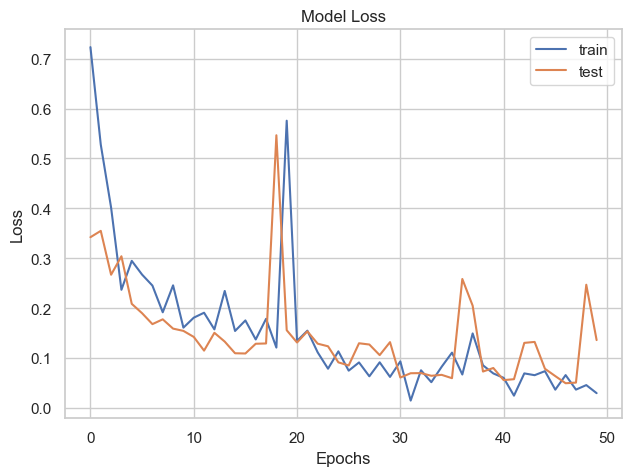

In [18]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

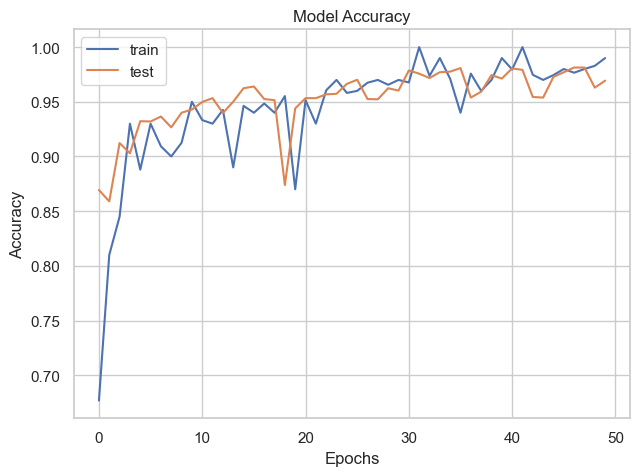

In [19]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()


<a id="content5"></a>
## 5 ) Visualizing Predictons on the Validation Set

In [29]:
# getting predictions on val set.
y_pred = model.predict(x_test) 
y_pred_classes = np.argmax(y_pred, axis=1) 
y_true = np.argmax(y_test, axis=1)

118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step


In [30]:
cm = confusion_matrix(y_true, y_pred_classes)

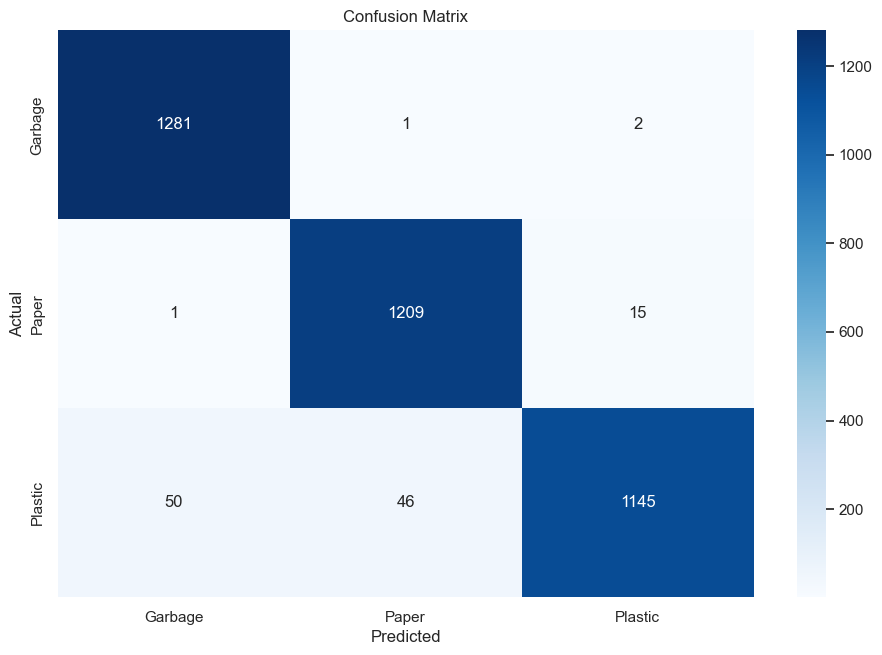

In [31]:
plt.figure(figsize=(10, 7)) 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_) 
plt.xlabel('Predicted') 
plt.ylabel('Actual') 
plt.title('Confusion Matrix') 
plt.show()

In [32]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

In [33]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(x_test, y_test)

# Print the accuracy
print(f"Model accuracy on test data: {accuracy * 100:.2f}%")


118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9693 - loss: 0.1291
Model accuracy on test data: 96.93%


#### CORRECTLY CLASSIFIED FLOWER IMAGES

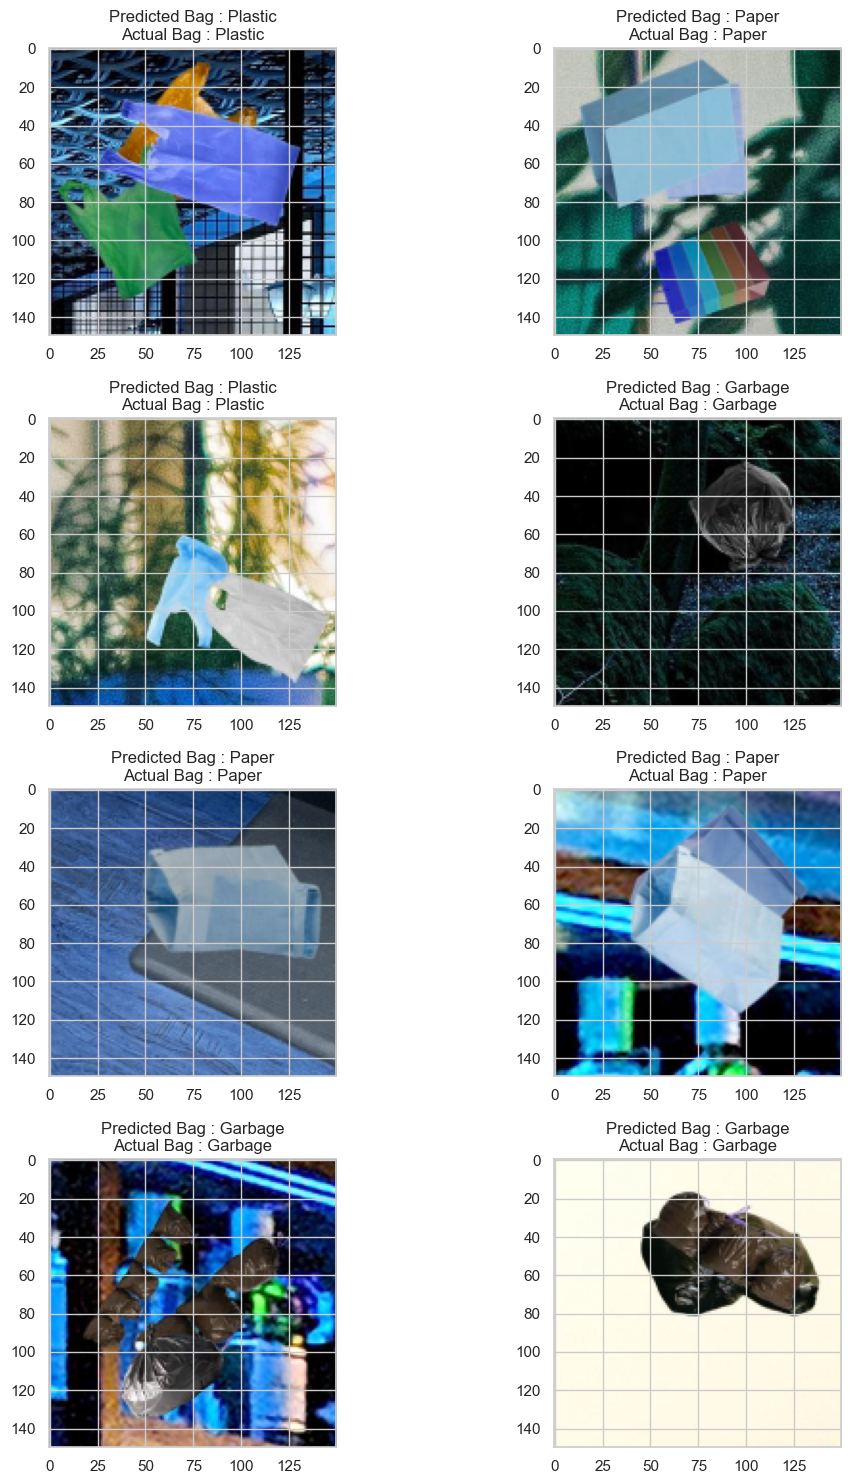

In [24]:
# import warnings
# import matplotlib.pyplot as plt

warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count = 0
fig, ax = plt.subplots(4, 2)
fig.set_size_inches(15, 15)
for i in range(4):
    for j in range(2):
        ax[i, j].imshow(x_test[prop_class[count]])
        predicted_bag = le.inverse_transform([pred_digits[prop_class[count]]])[0]
        actual_bag = le.inverse_transform([np.argmax(y_test[prop_class[count]])])[0]
        ax[i, j].set_title(f"Predicted Bag : {predicted_bag}\nActual Bag : {actual_bag}")
        plt.tight_layout()
        count += 1
plt.show()


#### MISCLASSIFIED IMAGES OF FLOWERS

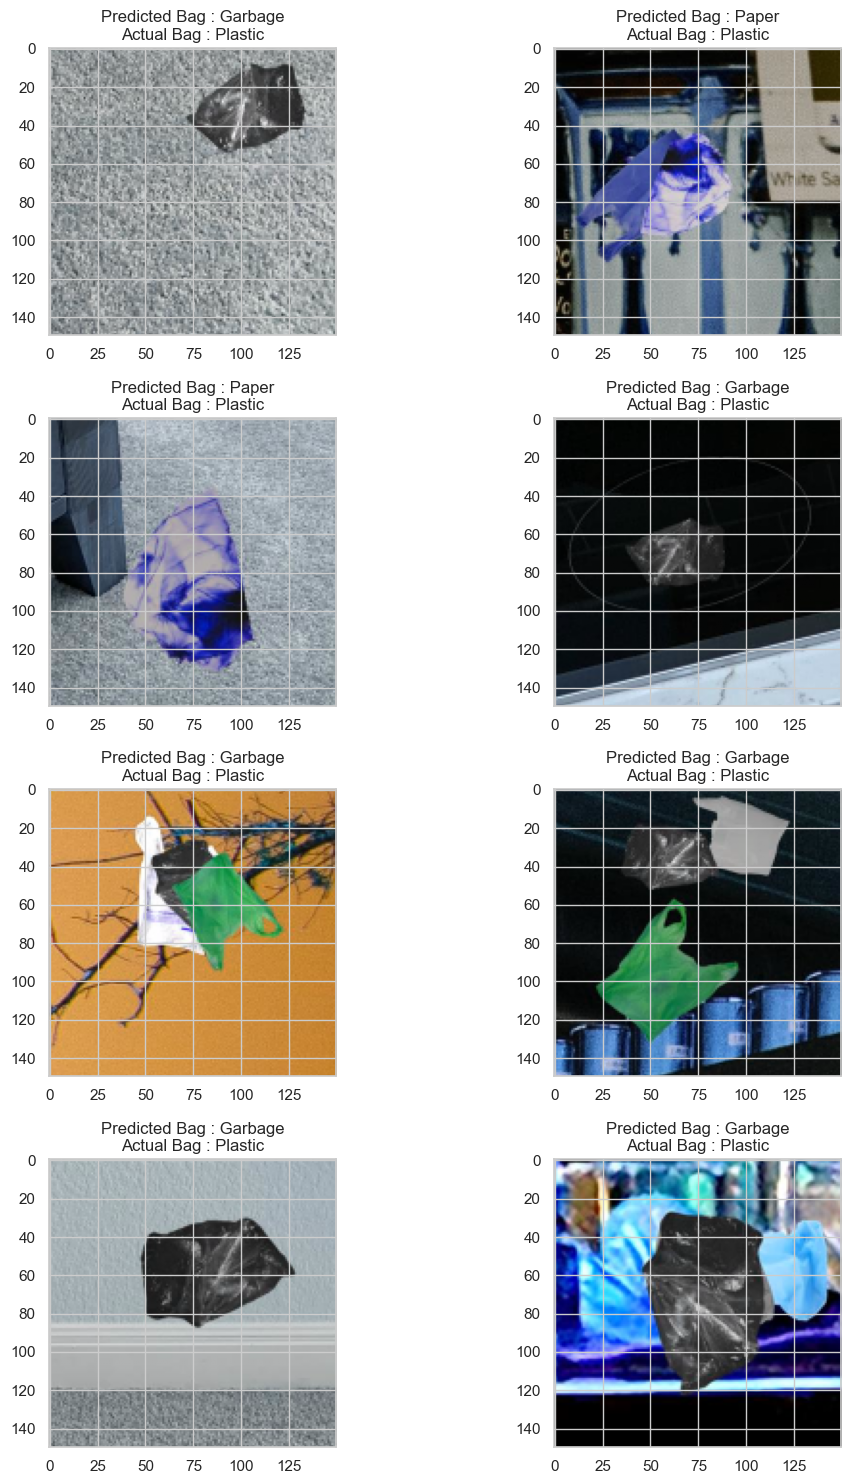

In [26]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count = 0
fig, ax = plt.subplots(4, 2)
fig.set_size_inches(15, 15)
for i in range(4):
    for j in range(2):
        ax[i, j].imshow(x_test[mis_class[count]])
        predicted_bag = le.inverse_transform([pred_digits[mis_class[count]]])[0]
        actual_bag = le.inverse_transform([np.argmax(y_test[mis_class[count]])])[0]
        ax[i, j].set_title(f"Predicted Bag : {predicted_bag}\nActual Bag : {actual_bag}")
        plt.tight_layout()
        count += 1
plt.show()


#Tesing with my own image

In [1]:
# import numpy as np
# import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize the image
    return img_array

def predict_image(model, img_array):
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    return predicted_class

# Path to your input image
img_path = 'my image/plastic2.jpg'  # Update this path to your own image

# Load and preprocess the image
img_array = load_and_preprocess_image(img_path)

# Predict using your model
predicted_class = predict_image(model, img_array)

# Decode the prediction
predicted_label = le.inverse_transform(predicted_class)[0]

# Display the image and prediction
plt.imshow(image.load_img(img_path))
plt.title(f'Predicted: {predicted_label}')
plt.axis('off')
plt.show()


NameError: name 'IMG_SIZE' is not defined

In [52]:
# Save the model in HDF5 format
model.save('my_model.h5')

#  THE END.

## [ Please upvote / star if you liked it. ]